# Comparing multiclass LightGBM classifiers for imbalanced darasets

## Imports, utilities

In [1]:
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix
from OneVsRestClassifierCustomizedLoss import *
from FocalLoss import FocalLoss
import lightgbm as lgb

### Plotting confusion matrix

In [2]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
X, y = make_classification(n_classes=3,
                           n_samples=10000,
                           n_features=4,
                           n_informative=3,
                           n_redundant=1,
                           weights=[.01, .02, .97],
                           random_state=42)

le = preprocessing.LabelEncoder()
y_label = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.30, random_state=42)

## Multiclass lightgbm 

In [4]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train, verbose=0)

LGBMClassifier()

train accuracy 1.0  train recall  1.0
prediction accuracy 0.976  prediction recall  0.6245870483072903
Normalized confusion matrix
[[0.32653061 0.08163265 0.59183673]
 [0.03448276 0.55172414 0.4137931 ]
 [0.00241963 0.00207397 0.99550639]]


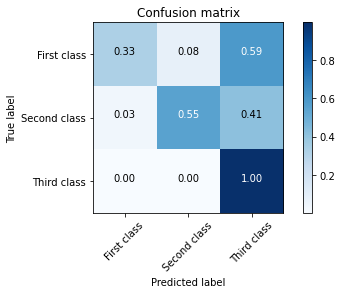

In [5]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

y_train_pred = clf.predict(X_train)
acc_score = accuracy_score(y_train, y_train_pred)
rec_score = recall_score(y_train, y_train_pred, average='macro')
print('train accuracy', acc_score,' train recall ', rec_score)
y_test_pred = clf.predict(X_test)
acc_score = accuracy_score(y_test, y_test_pred)
rec_score = recall_score(y_test, y_test_pred, average='macro')
print('prediction accuracy', acc_score,' prediction recall ', rec_score)

cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1, 2])
plot_confusion_matrix(cnf_matrix, classes=['First class','Second class', 'Third class'],normalize=True,  title='Confusion matrix')

## Multiclass lightgbm with focal loss

train accuracy 0.9622857142857143  train recall  0.3333333333333333
prediction accuracy 0.9643333333333334  prediction recall  0.3333333333333333
Normalized confusion matrix
[[0.32653061 0.08163265 0.59183673]
 [0.03448276 0.55172414 0.4137931 ]
 [0.00241963 0.00207397 0.99550639]]


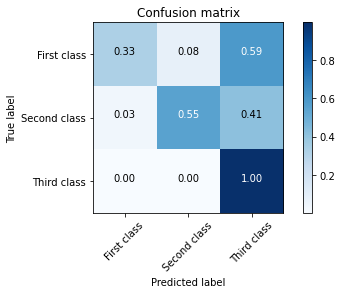

In [10]:
loss = FocalLoss(alpha=0., gamma=0.)
loss_fun = lambda y_true, y_pred: (loss.grad(y_true, special.expit(y_pred)), loss.hess(y_true, special.expit(y_pred)))
estimator = lgb.LGBMClassifier(objective=loss_fun)

clf = OneVsRestClassifierCustomizedLoss(estimator=estimator, loss=loss)

# If using early stopping, uncomment the following three lines
# eval_metric = lambda y_true, y_pred: ('focal_loss', loss(y_true, special.expit(y_pred)).sum(), False)
# fit_params = {'eval_set': [(X_test, y_test)], 'eval_metric': eval_metric}
# clf.fit(X_train, y_train, **fit_params)

clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
acc_score = accuracy_score(y_train, y_train_pred)
rec_score = recall_score(y_train, y_train_pred, average='macro')
print('train accuracy', acc_score,' train recall ', rec_score)
y_test_pred = clf.predict(X_test)
acc_score = accuracy_score(y_test, y_test_pred)
rec_score = recall_score(y_test, y_test_pred, average='macro')
print('prediction accuracy', acc_score,' prediction recall ', rec_score)

cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1, 2])
plot_confusion_matrix(cnf_matrix, classes=['First class','Second class', 'Third class'],normalize=True,  title='Confusion matrix')